# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: finetuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So,its a good idea to put functions you'l want to use again in a script you can download and import into your notebooks (or elsewhere).

Weve done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-27 14:44:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-02-27 14:44:30 (15.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# import helper function we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you are running this notebook in Google Colab, when it times out Colab will delete `helper_tunctions.py`, s0 you will have to redownload it if you want access to your helper functions.

## Lets get some data

“This time we'e going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [4]:
#  Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-27 14:44:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.201.155, 172.217.169.251, 192.178.24.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.201.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  4.70MB/s    in 36s     

2024-02-27 14:45:13 (4.44 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [4]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
tarin_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
tarin_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [7]:
#  Check out the clas name =s of our data set
tarin_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
#  See the example of a batch of data
for images , labels  in tarin_data_10_percent.take(1):
  print(images , labels)

tf.Tensor(
[[[[1.77142849e+01 1.67142849e+01 1.17142859e+01]
   [1.83112240e+01 1.73112240e+01 1.23112249e+01]
   [2.27091846e+01 1.97091846e+01 1.47091837e+01]
   ...
   [5.55714722e+01 3.93572083e+01 2.70000000e+01]
   [5.74285316e+01 3.94999733e+01 2.53570900e+01]
   [5.55562401e+01 3.85562401e+01 2.13827248e+01]]

  [[1.50255098e+01 1.40255098e+01 9.02550983e+00]
   [1.61377544e+01 1.31377544e+01 8.13775444e+00]
   [1.95714283e+01 1.65714283e+01 1.15714283e+01]
   ...
   [5.48418617e+01 3.78418617e+01 2.78418598e+01]
   [5.60612106e+01 3.80663109e+01 2.57805729e+01]
   [5.53112602e+01 3.77143555e+01 2.29081688e+01]]

  [[1.57091837e+01 1.17091837e+01 9.13775539e+00]
   [1.52551022e+01 1.12551022e+01 8.68367386e+00]
   [1.61683674e+01 1.19081631e+01 9.38265324e+00]
   ...
   [5.33826141e+01 3.63826141e+01 2.71478863e+01]
   [5.33724785e+01 3.53724785e+01 2.52602119e+01]
   [5.51989212e+01 3.71989212e+01 2.56274929e+01]]

  ...

  [[1.50611744e+01 1.10611744e+01 1.16326466e+01]
   [1

## Model 0 : Building a transfer learning Feature Extraction model using the keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more Flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# 2. Freeze the base model (so underlying pre-trained patterns arenot updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using a model like  ResNet50V2 yu will need to normalize inputs (you donot have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5.  Pass the inputs to the base_model
x = base_model (inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most inmportant information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name =  "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the activation output layers
outputs = tf.keras.layers.Dense(10 , activation = tf.keras.activations.softmax, name = "output_layers" )(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model
history_10_percent  = model_0.fit(tarin_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch =len(tarin_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = int (0.25 * len(test_data)),
                                  callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                           experiment_name = "10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240227-170508
Epoch 1/5
24/24 [==============================] - 15s 629ms/step - loss: 1.8864 - accuracy: 0.4160 - val_loss: 1.4812 - val_accuracy: 0.6562
Epoch 2/5
24/24 [==============================] - 13s 551ms/step - loss: 1.1402 - accuracy: 0.7453 - val_loss: 0.8596 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 13s 551ms/step - loss: 0.8381 - accuracy: 0.7947 - val_loss: 0.8612 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 13s 559ms/step - loss: 0.6826 - accuracy: 0.8427 - val_loss: 0.7569 - val_accuracy: 0.6875
Epoch 5/5
24/24 [==============================] - 14s 568ms/step - loss: 0.5975 - accuracy: 0.8680 - val_loss: 0.6580 - val_accuracy: 0.8438


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

In [11]:
#  Check the layers in our base model
for layer_number, layer in enumerate (base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [12]:
# How about we get the summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         multiple             0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) multiple             7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   multiple             0           normalization_1[0][0]            
_____________________________________________________________________________________

In [13]:
#  How about a summary of our whole model?
model_0.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


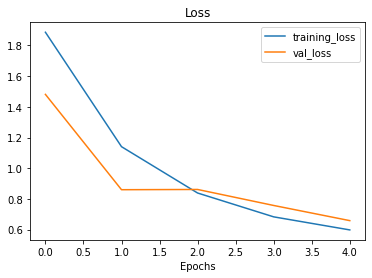

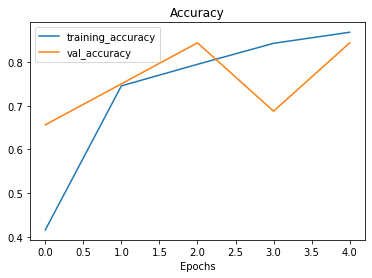

In [14]:
#  Check out our models 's loss curves
plot_loss_curves(history_10_percent)

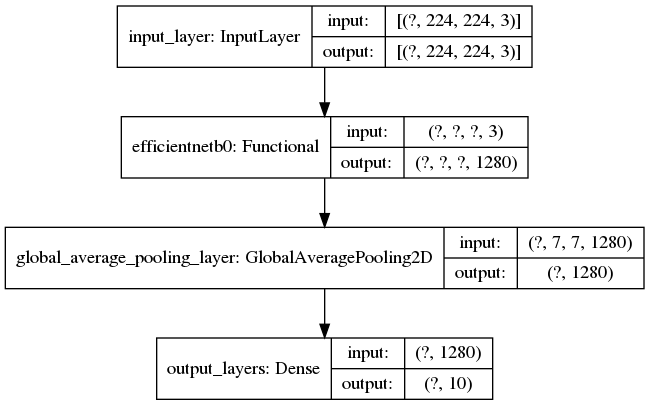

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model_0,  show_shapes=True, show_layer_names=True)

## Getting a featurs vector from a trained model

Lets demostrate the Global Average pooling 2D layers ...

We have a tensor after our model goes through `base_ model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Lets use a similar shaped tensor of (1,4,4,3) and pass it to GlobalAveragePooling2D

In [16]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print (f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layers
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print (f"2D global average pooled random tensor: \n{global_average_pooled_tensor}\n")

# Check the shape of different tensor
print (f"shape of Random input tensor :\n {input_tensor.shape}\n")
print (f"shape of 2D global average pooled random tensor: \n{global_average_pooled_tensor.shape}\n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor: 
[[-0.09368646 -0.45840445 -0.28855976]]

shape of Random input tensor :
 (1, 4, 4, 3)

shape of 2D global average pooled random tensor: 
(1, 3)



In [17]:
#  Lets replicate the GlobalAverage2D layers
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> Practice: Try to do the same with the above two cells but this time use GlobalMaxPoo12D.. and see what happens.

> 🔑**Note:** One of the reasons feature extraction transfer learning is named how it is i because what often happens is pretrained
model outputs a feature vector (a long tensor of numbers which represents the learned  representation of the model on a
particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract pattems out of for our own specifc problem.

## Running a series of transfer learning experiments

We have seen the icredible results transfer learning can get with only 10% of the training data , but how does it go with 1% of the training data how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3` - use fine tuning  transfer learning with 10% of the training data with data augmentation

4. `model_3` - use fine tuning  transfer learning with 100% of the training data with data augmentation

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and Preprocessing data for model_1

In [20]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-02-27 14:48:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.180.59, 192.178.24.219, 192.178.24.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.180.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  3.89MB/s    in 35s     

2024-02-27 14:49:23 (3.69 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [19]:
#  How mant images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [20]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

tarin_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`
We can see the benefits of doing this within the TensorFlow
Data augmentation documentation:
https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

* Preprocessing of imges (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

----
There are two important points to be aware of in this data_augmentation layer :
* Data augmentation will run on-device, synchronously with the rest of your layers,and benefit from GPU acceleration.
* When you export your model using `model. save` , the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the
configuration of your layers). This can save you from the effort of having to reimplement that logic serverside.



In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping , rotations , zoom etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)  # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
    ], name = "data_augmentation")

### Visulize our data augmentation layers (see what happened to our data)

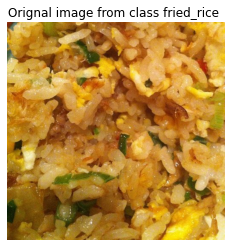

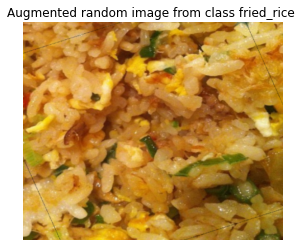

In [22]:
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(tarin_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_images = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_images

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title (f"Orignal image from class {target_class} ")
plt.axis(False);

# Now let plot our augmented image
augmented_img = data_augmentation(tf.expand_dims(img,axis =0))
plt.figure()
plt.imshow(tf.squeeze (augmented_img)/255. )
plt.title (f"Augmented random image from class {target_class} ")
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input and base model , freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.Input(shape = input_shape , name = "Input_layers")

# Add in data_augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation ) and donot train it
x = base_model (x, training = False)

# Pool output feature of the base model
x =  layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

#  Put a Dense layer on as output
outputs = layers.Dense(10, activation = tf.keras.activations.softmax, name = "output_layer")(x)

# Make model using inputs and output
model_1 = keras.Model(inputs , outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(tarin_data_1_percent,
                                epochs =5,
                                steps_per_epoch=len(tarin_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name = "1_percent_dat_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_dat_aug/20240227-170713
Epoch 1/5
3/3 [==============================] - 2s 776ms/step - loss: 2.4088 - accuracy: 0.0571 - val_loss: 2.3085 - val_accuracy: 0.0625
Epoch 2/5
3/3 [==============================] - 1s 483ms/step - loss: 2.1534 - accuracy: 0.1286 - val_loss: 2.1066 - val_accuracy: 0.3750
Epoch 3/5
3/3 [==============================] - 2s 500ms/step - loss: 2.0244 - accuracy: 0.3143 - val_loss: 2.0412 - val_accuracy: 0.3125
Epoch 4/5
3/3 [==============================] - 2s 543ms/step - loss: 1.8585 - accuracy: 0.4571 - val_loss: 1.9381 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 1s 483ms/step - loss: 1.7056 - accuracy: 0.5286 - val_loss: 1.8231 - val_accuracy: 0.5000


In [24]:
model_1.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layers (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate on the full test dataset
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

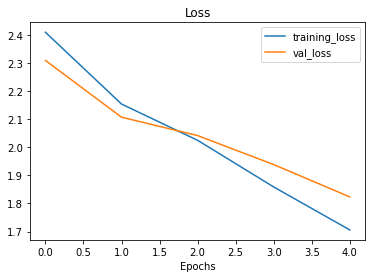

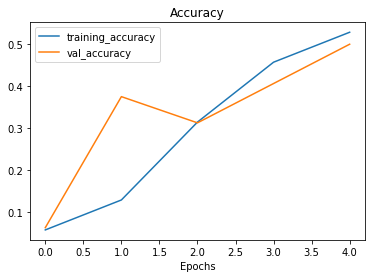

In [25]:
#  How do the model with 1 percent of the data augmentation loss curves look ?
plot_loss_curves(history_1_percent)

## Model 2 : feature extraction trasfer learning model with 10% of the data and data augmentation

In [26]:
#  get the 10% of data
#  already download at the start

train_dir_10_percent =  "10_food_classes_10_percent/train"
test_dir_10_percent =  "10_food_classes_10_percent/test"

In [27]:
# How many images in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [28]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224 , 224)
tarin_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.)
], name = "data_augmentation")


# Setup input and base model , freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.Input(shape = input_shape , name = "Input_layers")

# Add in data_augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation ) and donot train it
x = base_model (x, training = False)

# Pool output feature of the base model
x =  layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

#  Put a Dense layer on as output
outputs = layers.Dense(10, activation = tf.keras.activations.softmax, name = "output_layer")(x)

# Make model using inputs and output
model_2 = keras.Model(inputs , outputs)

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [30]:
model_2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layers (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can
come and start where we left off.

In [31]:
# Set checkpoint path |
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint (filepath= checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq="epoch", # save every epoch
                                                          verbose=1)

### Fit  model_2 passing in the ModelCheckpoint Calllback

In [32]:
# fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(tarin_data_10_percent,
                                epochs = initial_epochs,
                                steps_per_epoch=len(tarin_data_10_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name = "10_percent_dat_aug"),
                                             checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_dat_aug/20240227-170808
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0085 - accuracy: 0.3253
Epoch 00001: val_loss improved from inf to 1.49067, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 595ms/step - loss: 2.0085 - accuracy: 0.3253 - val_loss: 1.4907 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3772 - accuracy: 0.6547
Epoch 00002: val_loss improved from 1.49067 to 1.17465, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 590ms/step - loss: 1.3772 - accuracy: 0.6547 - val_loss: 1.1746 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0822 - accuracy: 0.7133
Epoch 00003: val_loss improved from 1.17465 to 0.88621, saving model to ten_percent_model_checkpoints_weights/checkpoint.ck

In [37]:
# What were model 0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 43s 550ms/step - loss: 0.6028 - accuracy: 0.8380


[0.6027708053588867, 0.8379999995231628]

In [38]:
# Check model 2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 43s 546ms/step - loss: 0.7442 - accuracy: 0.7988


[0.7442447543144226, 0.798799991607666]

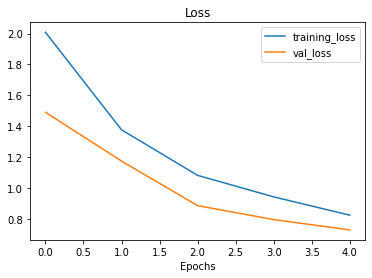

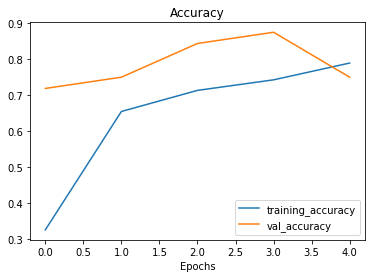

In [33]:
# Plot model loss curves i
plot_loss_curves (history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [34]:
# checkpoint_path
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [35]:
# Load in saved model weights and evaluate model
model_2.load_weights (checkpoint_path)

In [36]:
# Evalaute model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 46s 586ms/step - loss: 0.7379 - accuracy: 0.7964


In [43]:
# If the results from our previously evaluated model 2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.7442447543144226, 0.798799991607666]

In [45]:
loaded_weights_model_results

[0.7442445755004883, 0.798799991607666]

In [46]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [47]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug)- np.array(loaded_weights_model_results))

[1.78813934e-07 0.00000000e+00]


## Model 3: Fine-tuning an exsisting model on 10% of data

> **Note:** Fine-tuning usually works best after raining a feature extraction model for a few epochs with large amounts of custom
data.

In [37]:
model_2.layers

In [38]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer , layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f92819d7400> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f928617c550> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9281a39828> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f92819aa748> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f92819aa7f0> True


In [39]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i , layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name,  layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [40]:
# How many trainable variables are in out base model?
print(len(model_2.layers[2].trainable_variables))

0


In [41]:
# To begin fine-tuning lets start by setting the lase 10 layers of our base_model.trainable  = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change )
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics = ["accuracy"])

> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim other values). A good resource for information on this is the ULMFIT paper: https://anxiv.org/abs/1801.06146.


In [42]:
# check which layers are tuneable (trainable)
for i , layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name,  layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [43]:
# Now we have unfrozen some of the layers closer to the top , how many trainable variable are there?
print(len(model_2.trainable_variables))

12


In [44]:
# Fine tune for another 5 epochs
fine_tune_epochs =  initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers )
history_fine_10_percent_data_aug = model_2.fit(tarin_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               steps_per_epoch=len(tarin_data_10_percent),
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tube_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tube_last_10/20240227-171128
Epoch 5/10
24/24 [==============================] - 15s 639ms/step - loss: 0.7115 - accuracy: 0.7853 - val_loss: 0.3243 - val_accuracy: 0.9375
Epoch 6/10
24/24 [==============================] - 15s 609ms/step - loss: 0.5682 - accuracy: 0.8213 - val_loss: 0.7157 - val_accuracy: 0.6875
Epoch 7/10
24/24 [==============================] - 15s 615ms/step - loss: 0.5191 - accuracy: 0.8440 - val_loss: 0.6584 - val_accuracy: 0.7188
Epoch 8/10
24/24 [==============================] - 16s 652ms/step - loss: 0.4743 - accuracy: 0.8613 - val_loss: 0.4309 - val_accuracy: 0.8750
Epoch 9/10
24/24 [==============================] - 16s 668ms/step - loss: 0.4551 - accuracy: 0.8573 - val_loss: 0.4050 - val_accuracy: 0.8125
Epoch 10/10
24/24 [==============================] - 15s 608ms/step - loss: 0.4398 - accuracy: 0.8653 - val_loss: 0.7268 - val_accuracy: 0.7188


In [56]:
 # Evaluate the fine-tuned model (model 3 which is actualy model ? fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 44s 555ms/step - loss: 0.5192 - accuracy: 0.8256


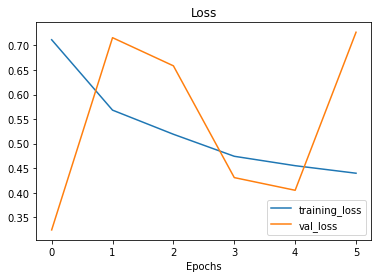

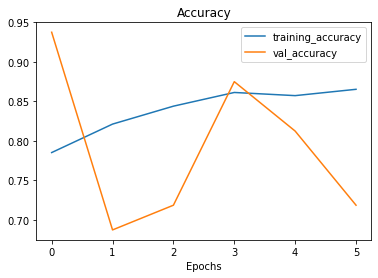

In [45]:
# Check the loss courves of our fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [46]:
# Lets create a function to compare training histories
def compare_historys(original_history, new_history, initial_epoch = 5):
  """
  compare two Tensorflow History Objects
  """
  # Get the orignal history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # combine orignal history with new history metrics
  total_acc = acc +new_history.history["accuracy"]
  total_loss = loss +new_history.history["loss"]

  total_val_acc = val_acc +new_history.history["val_accuracy"]
  total_val_loss = val_loss +new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc , label = "Training_Accuracy")
  plt.plot(total_val_acc , label = "Val_Accuracy")
  plt.plot([initial_epochs-1 ,initial_epochs-1], plt.ylim(), label = "Start Fine Tunning" )
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss , label = "Training_Loss")
  plt.plot(total_val_loss , label = "Val_Loss")
  plt.plot([initial_epochs-1 ,initial_epochs-1], plt.ylim(), label = "Start Fine Tunning" )
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")


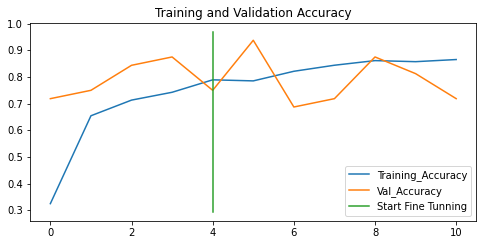

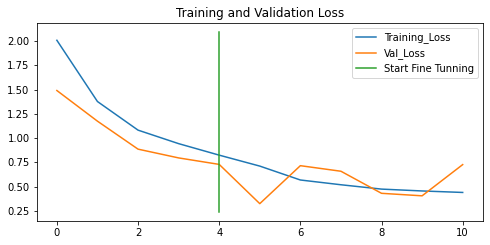

In [47]:
compare_historys(original_history = history_10_percent_data_aug, new_history= history_fine_10_percent_data_aug, initial_epoch = 5)

## Model 4: Fine-tuning on exsisting Model on all of the data

In [60]:
# Download and unzip 10 classes of Food101 data with all images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-02-27 15:01:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.24.251, 216.58.209.155, 142.250.185.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.24.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  3.82MB/s    in 2m 14s  

2024-02-27 15:03:52 (3.70 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [48]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"


In [49]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [50]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224 , 224)
tarin_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test
dataset).

Let's verify this...

In [51]:
#  Evaluate model 2 (this is the fine-tunned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 46s 577ms/step - loss: 0.5238 - accuracy: 0.8280


[0.5237979888916016, 0.828000009059906]

In [52]:
results_fine_tune_10_percent

NameError: name 'results_fine_tune_10_percent' is not defined

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [53]:
"""
Load weights from checkpoit , that way we can fine-tune from
the stage the 10-percent data model was fine-tuned from
"""

model_2.load_weights(checkpoint_path)

In [54]:
# lets evaluate the model_2 now on previous checkpoints
model_2.evaluate(test_data)

79/79 [==============================] - 45s 569ms/step - loss: 0.7379 - accuracy: 0.7964


[0.737904965877533, 0.7964000105857849]

In [58]:
# Check to see of our model_2 has been reverted back to feature extraction results 
results_10_percent_data_aug

Alright, the previous steps might seem quite confusing but all
we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model 3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)



In [62]:
# Check Which layers are trainable in the model
for layer_number , layer in enumerate(model_2.layers):
  print(layer_number , layer.name,  layer.trainable)

0 Input_layers True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [63]:
# Lets drill into our base_model (efficentB0) and see what layers and see what layers are trainabele
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name,  layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [64]:
# Compile 
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])

In [65]:
# Continue to train and fine-tune the model to our data (100% of training data)
# Fine tune for another 5 epochs
fine_tune_epochs =  initial_epochs + 5


history_fine_10_classes_full = model_2.fit(tarin_data_10_classes_full,
                                               epochs = fine_tune_epochs,
                                               steps_per_epoch=len(tarin_data_10_classes_full),
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240227-173749
Epoch 5/10
235/235 [==============================] - 186s 793ms/step - loss: 0.7608 - accuracy: 0.7507 - val_loss: 0.6266 - val_accuracy: 0.8125
Epoch 6/10
235/235 [==============================] - 181s 772ms/step - loss: 0.6106 - accuracy: 0.8011 - val_loss: 0.4520 - val_accuracy: 0.9062
Epoch 7/10
235/235 [==============================] - 184s 785ms/step - loss: 0.5404 - accuracy: 0.8248 - val_loss: 0.3449 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 179s 762ms/step - loss: 0.5070 - accuracy: 0.8360 - val_loss: 0.3196 - val_accuracy: 0.9375
Epoch 9/10
235/235 [==============================] - 185s 787ms/step - loss: 0.4689 - accuracy: 0.8509 - val_loss: 0.2613 - val_accuracy: 0.9375
Epoch 10/10
235/235 [==============================] - 191s 813ms/step - loss: 0.4377 - accuracy: 0.8580 - val_loss: 0.1646 - val_accuracy: 0.9375


In [66]:
# lets evaluate on all of the test data
result_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 59s 746ms/step - loss: 0.3125 - accuracy: 0.8988


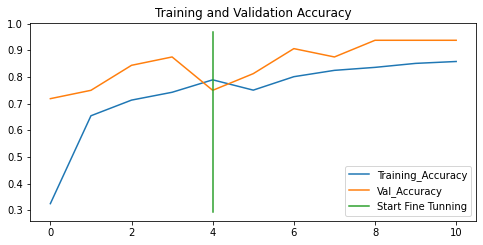

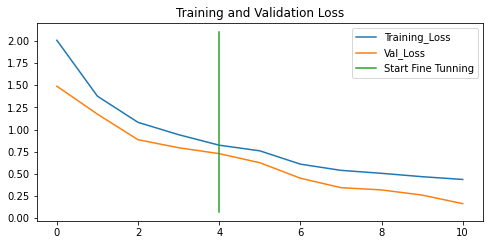

In [67]:
# How did fine-tuning go with more data ?
compare_historys(original_history = history_10_percent_data_aug, 
                 new_history= history_fine_10_classes_full, 
                 initial_epoch = 5)

## Viewing our experiment data on TensorBoard

In [68]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiment with 10 Food101 classes " \
--discription "A series of different transfer learning experiments with varying amount of data and fine tuning."\
--one_shot #exit the uploader once its finished uploading


2024-02-27 17:57:42.363371: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-27 17:57:42.363391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: --discription A series of different transfer learning experiments with varying amount of data and fine tuning.


My TensorBoard experiments are available at: https:/tensorboard.dev/experiment/veySzjmkRKKBLVSJAQMO8g/

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2024-02-27 18:00:07.984487: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-27 18:00:07.984509: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

In [ ]:
#  To delete an experiment
# !tensorboard dev delete --experiment_id experiment_id